In [1]:
%matplotlib inline

In [2]:
from pylab import *
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
import scipy.interpolate

In [3]:
file_name = 'subhalo_411321_parameters.dat'
data = loadtxt(file_name)
snapshot       = data[:,0]
t              = data[:,1]
X_center_stars = data[:,2:5]
phi_inertia    = data[:,5]
theta_inertia  = data[:,6]
phi_L          = data[:,7]
theta_L        = data[:,8]
M_disk         = data[:,9]
a_mn           = data[:,10]
b_mn           = data[:,11]
X_center_halo  = data[:,12:15]
M_halo_plummer = data[:,15]
b_halo_plummer = data[:,16]
rho_0_nfw      = data[:,17]
b_nfw          = data[:,18]
lsq_nfw        = data[:,19]

Halo is on average x52 more massive and x53 larger than the disk


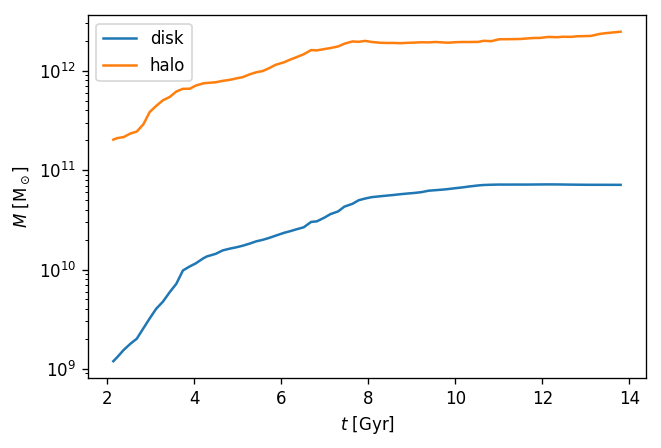

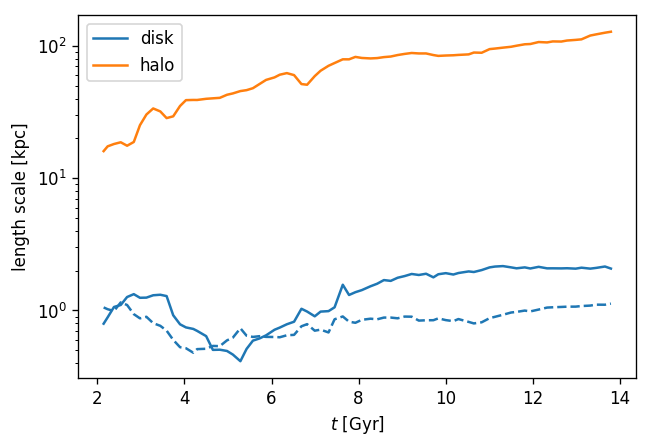

In [4]:
semilogy(t, M_disk)
semilogy(t, M_halo_plummer)
xlabel('$t$ [Gyr]')
ylabel('$M\ [\mathrm{M}_\odot]$')
legend(('disk', 'halo'))

figure()
semilogy(t, a_mn, c='C0', label='disk')
semilogy(t, b_mn, c='C0', ls='--')
semilogy(t, b_halo_plummer, c='C1', label='halo')
xlabel('$t$ [Gyr]')
ylabel('length scale [kpc]')
legend()

print(f'Halo is on average x{mean(M_halo_plummer/M_disk):.0f} more massive and x{mean(b_halo_plummer/a_mn):.0f} larger than the disk')

Maximum distance between stellar and halo centres is 0.76 kpc


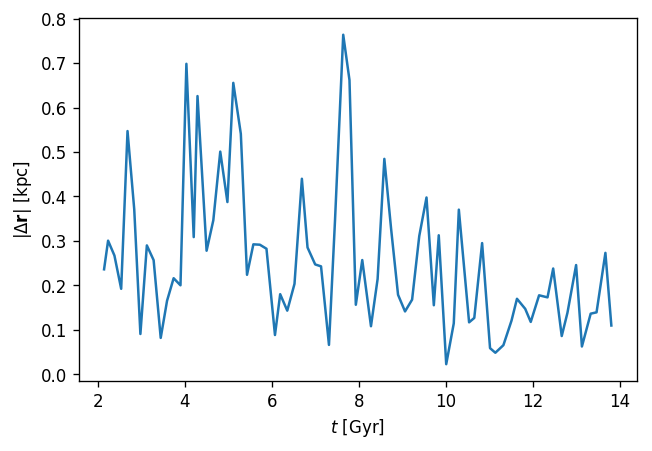

In [5]:
distance = linalg.norm(X_center_stars - X_center_halo, axis=1)
plot(t, distance)
xlabel('$t$ [Gyr]')
ylabel(r'$|\Delta \mathbf{r}|$ [kpc]')
print(f'Maximum distance between stellar and halo centres is {distance.max():.2f} kpc')

Text(0, 0.5, '$b/a$')

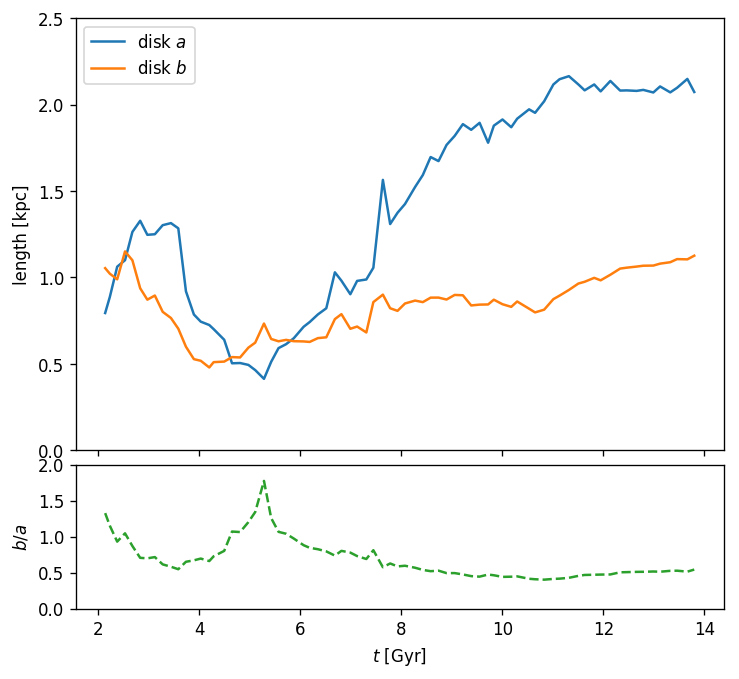

In [6]:
axes([0.05,0.33,0.9,0.9])
plot(t, a_mn)
plot(t, b_mn)
legend(('disk $a$', 'disk $b$'))
ylabel('length [kpc]')
ylim(0, 2.5)
gca().set_xticklabels([])
axes([0.05,0.0,0.9,0.3])
plot(t, b_mn/a_mn, '--', c='C2')
ylim(0,2)
xlabel('$t$ [Gyr]')
ylabel('$b/a$')

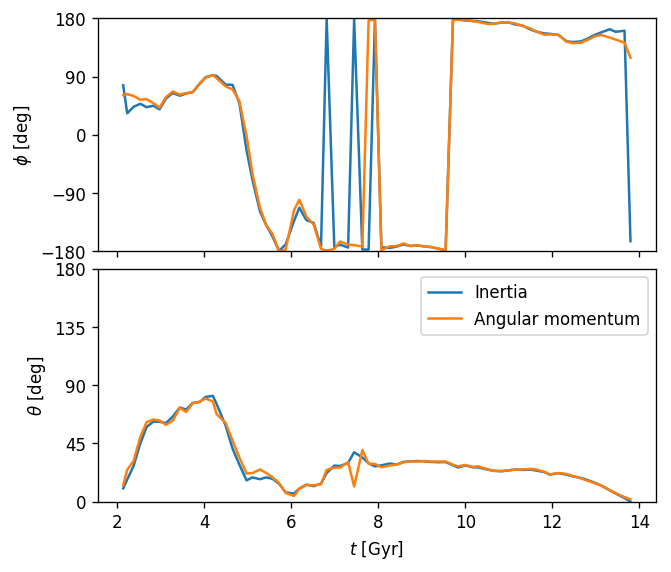

In [7]:
figsize = rcParams['figure.figsize']
figure(figsize=[figsize[0], figsize[1]*4/3])
subplot(211)
plot(t, rad2deg(phi_inertia))
plot(t, rad2deg(phi_L))
ylabel(r'$\phi$ [deg]')
ylim(-180,180)
gca().set_xticklabels([])
gca().yaxis.set_ticks([-180,-90,0,90,180])
subplot(212)
plot(t, rad2deg(theta_inertia))
plot(t, rad2deg(theta_L))
xlabel(r'$t$ [Gyr]')
ylabel(r'$\theta$ [deg]')
gca().yaxis.set_ticks([0,45,90,135,180])
ylim(0,180)
legend(('Inertia', 'Angular momentum'))
subplots_adjust(hspace=0.075)

Text(0, 0.5, '$\\phi$ [deg]')

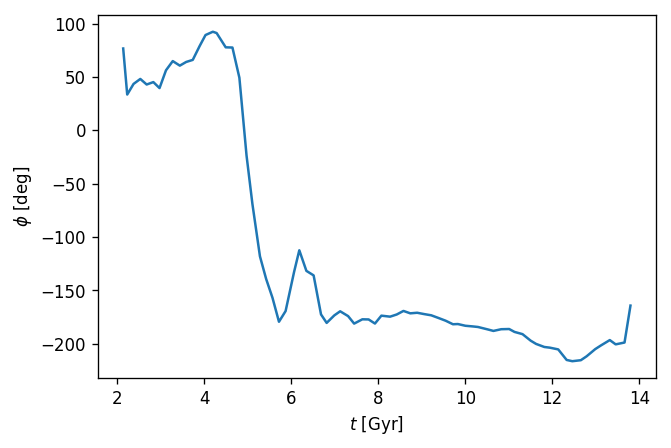

In [8]:
# Make sure we don't have these weird jumps between -180 to +180
def fix_continuity(input_array, threshold_factor=0.95):
    arr = input_array.copy()
    threshold = threshold_factor*2*pi
    for i in range(1, len(arr)):
        if arr[i] - arr[i-1] >  threshold: arr[i] -= 2*pi
        if arr[i] - arr[i-1] < -threshold: arr[i] += 2*pi
    return arr
phi_inertia_fixed = fix_continuity(phi_inertia)
plot(t, rad2deg(phi_inertia_fixed))
xlabel(r'$t$ [Gyr]')
ylabel(r'$\phi$ [deg]')

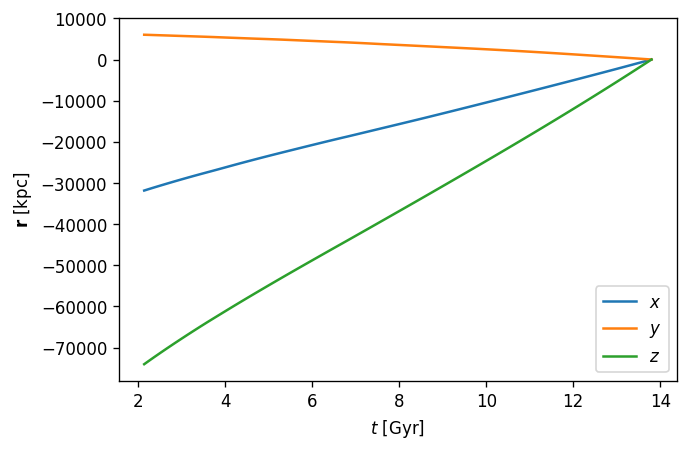

In [9]:
# Inspecting the coordinates of the centre as a function of time
# Hopefully they look kinda like straight lines
plot(t, X_center_stars)
xlabel('$t$ [Gyr]')
ylabel('$\mathbf{r}$ [kpc]')
legend(('$x$', '$y$', '$z$'))

Text(0, 0.5, '$\\mathbf{r}_\\mathrm{corrected}$ [kpc]')

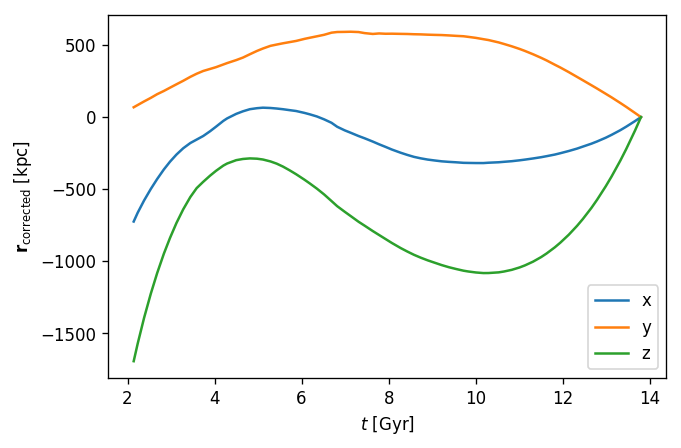

In [10]:
# Calculate the average velocity throughout cosmic time and subtract such that we only see the residual motion

Vx, _ = polyfit(t, X_center_stars[:,0], 1)
Vy, _ = polyfit(t, X_center_stars[:,1], 1)
Vz, _ = polyfit(t, X_center_stars[:,2], 1)
V = array([Vx, Vy, Vz])
legend(('$x$', '$y$', '$z$'))

X_adjusted = X_center_stars-V*(t-t[-1])[:,None]
plot(t, X_adjusted)
legend(('x', 'y', 'z'))
xlabel('$t$ [Gyr]')
ylabel('$\mathbf{r}_\mathrm{corrected}$ [kpc]')

Text(0, 0.5, '$\\mathbf{r}_\\mathrm{corrected}$ [kpc]')

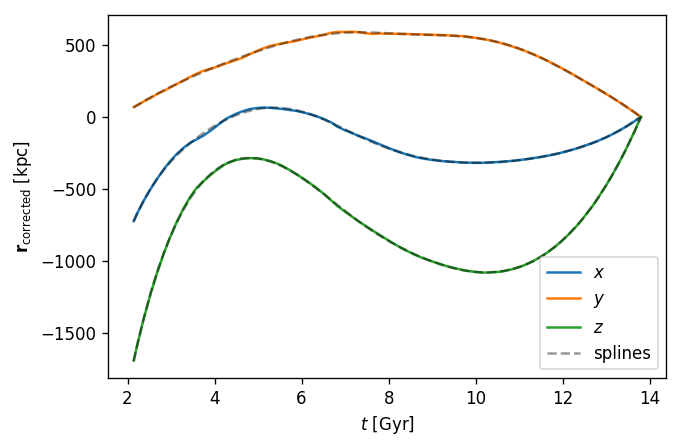

In [11]:
# Fit a relatively low order B-spline to each
k = 6 # Spline order
midpoint = 0.5*(t[0]+t[-1])
knots = r_[[t[0]]*(k+1), midpoint, midpoint, midpoint, [t[-1]]*(k+1)]
spline = scipy.interpolate.make_lsq_spline(t, X_adjusted, knots, k)
plot(t, X_adjusted)
plot(t, spline(t), c='k', alpha=0.4, ls='--')
legend(('$x$', '$y$', '$z$', 'splines'))
xlabel('$t$ [Gyr]')
ylabel('$\mathbf{r}_\mathrm{corrected}$ [kpc]')

Text(0, 0.5, 'acceleration [kpc/Gyr${}^2$]')

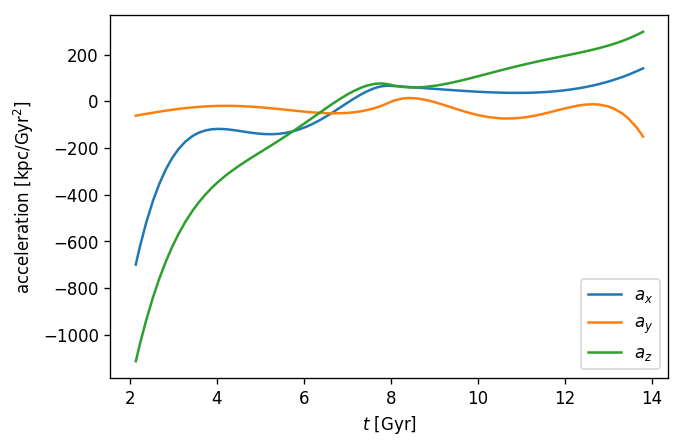

In [12]:
# Calculate acceleration from the splines
acc = spline(t, 2)
plot(t, acc)
legend(('$a_x$', '$a_y$', '$a_z$', 'splines'))
xlabel('$t$ [Gyr]')
ylabel('acceleration [kpc/Gyr${}^2$]')

Text(0, 0.5, 'acceleration [kpc/Gyr${}^2$]')

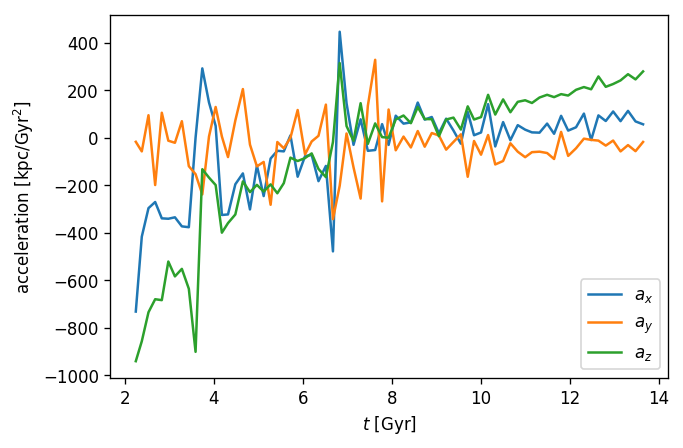

In [13]:
# Try the numerical derivative instead of the B-splines
V_ = diff(X_center_stars, axis=0)/diff(t)[:,None]
t_ = 0.5*(t[1:] + t[:-1])
A_ = diff(V_, axis=0)/diff(t_)[:,None]
t_ = 0.5*(t_[1:] + t_[:-1])
plot(t_, A_)
legend(('$a_x$', '$a_y$', '$a_z$', 'splines'))
xlabel('$t$ [Gyr]')
ylabel('acceleration [kpc/Gyr${}^2$]')

In [14]:
output_file_name = file_name[:-4] + '_processed.dat'
#X_adjusted[:,0] = t*1000
#X_adjusted[:,1] = -t*500
#X_adjusted[:,2] = 0
with open(output_file_name, 'w') as f:
    for i in range(len(snapshot)):
        output_string = '%d %.8E   %15.8E %15.8E   %.8E %.8E %.8E   %.8E %.8E\n' % (
            snapshot[i],
            t[i],
            phi_inertia_fixed[i], theta_inertia[i],
            M_disk[i], a_mn[i], b_mn[i],
            rho_0_nfw[i], b_nfw[i],
        )
        f.write(output_string)